## Initial Data Analysis of the Unlabeled Tweet Data

This analysis looks at summary statistics and high-level descriptives within the sample of tweets scraped from Fortune 100 companies and associated CEO Twitter accounts +/- 3 weeks around May 25th, 2020. I first look at descriptive statistics, turning special attention to the underlying generating process of the data (how companies tweet) and some high level characteristics of highly liked and retweeted content.

I then turn to link the tweet data to data from Compustat, which contains CEO, company, and industry features. I continue with similar high level analyses of descriptive statistics, providing initial clues into the tweeting behavior of individual companies. Portions of this descriptive analysis approach and code are inspired from Aurelion Gerón's [<u>Hands on Machine Learning, 2nd Edition</u>](https://github.com/ageron/handson-ml2).


Future analyses will delve into more detailed classification, text, and regression analyses. Specifically, following the analysis in this notebook, I will proceed in two parallel steps.

1. I will hire two Upwork data entry specialists to provide labels for each tweet instance. They will input two binary (0/1) features from this data:
    * Initial stance on the George Floyd incident
    * "Follow-up" action (e.g., giving money to equity non-profits, highlighting black workers in the org, etc.) 
<br><br>

2. Perform text cleaning and more rigorous text descriptives: I'll begin by cleaning tweet data in order to tokenize it for future analyses. Using patterns from this descriptive statistics analysis, I will create word visualizations on the unlabeled data to provide initial insights into language patterns in the tweet sample. This analysis will be found in "X.X-pjr-2-cleaning-word-viz".

In [1]:
import sys
assert sys.version_info >= (3, 5)

import pandas as pd
import numpy as np
import datetime as dt

# Import Matplotlib and Seaborn
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

#Import helpful user-defined functions for directories in nb_functions.py
from nb_functions import set_project_root, change_dir

PROJECT_ROOT = set_project_root()

### 1. High level descriptives of the tweet data

In [2]:
# Change the directory to download the data and return to the notebooks folder.
change_dir(PROJECT_ROOT, '/data')
df = pd.read_csv('tweets_df_raw.csv')

      
New Working Directory: ~/data


In [3]:
df.head()
df = df.drop(df.columns[0], 1) # Delete the "Unnamed" column, which is a duplicate of the index

In [4]:
df.head()

,date,tweet_id,text,replies,retweets,likes,quotes,media,source_label,username,ceo_account,compustat_company,user_join_date,user_followers,user_friends,user_statuses,user_favorites,user_listed,user_media
0,2020-06-12T00:17:58+00:00,1271235256918487040,An important update from @SusanWojcicki on how...,85,187,1689,14,NaN,Twitter Web App,sundarpichai,1,ALPHABET INC,2008-03-12T05:51:53+00:00,3431958,351,1486,893,7561,111
1,2020-06-11T06:37:29+00:00,1270968380304941058,Proud that @GoogleCloud is partnering with @Te...,71,416,1937,47,NaN,Twitter Web App,sundarpichai,1,ALPHABET INC,2008-03-12T05:51:53+00:00,3431958,351,1486,893,7561,111
2,2020-06-11T05:52:43+00:00,1270957112097570816,Also excited that in #Android11 we're making i...,89,406,3020,48,NaN,Twitter Web App,sundarpichai,1,ALPHABET INC,2008-03-12T05:51:53+00:00,3431958,351,1486,893,7561,111
3,2020-06-11T05:44:05+00:00,1270954939309645824,"Android 11 is now available in beta, with a fo...",152,707,5377,45,NaN,Twitter Web App,sundarpichai,1,ALPHABET INC,2008-03-12T05:51:53+00:00,3431958,351,1486,893,7561,111
4,2020-05-31T14:03:32+00:00,1267094364976672768,Today on US Google &amp; YouTube homepages we ...,1737,6360,37997,700,photo,Twitter Web App,sundarpichai,1,ALPHABET INC,2008-03-12T05:51:53+00:00,3431958,351,1486,893,7561,111


In [5]:
# Strip date and time information from original "date" feature
df['date_'] = df.date.str[:10]
df['utc_time'] = df.date.str[11:19]

In [6]:
# Convert date and time to DateTime types

In [7]:
df['date_'] = pd.to_datetime(df['date_'])
df['event_date'] = '2020-05-25'
df['event_date'] = pd.to_datetime(df['event_date'])
df['date_'].fillna(0)
df['event_date'].fillna(0)

df['utc_time'] = pd.to_datetime(df['utc_time']).dt.strftime('%H%M%S')

# Drop original date column, rename "date_" column as "date"
df = df.drop(columns=['date'])
df = df.rename(columns={'date_': 'date'})

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41532 entries, 0 to 41531
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   tweet_id           41532 non-null  int64         
 1   text               41532 non-null  object        
 2   replies            41532 non-null  int64         
 3   retweets           41532 non-null  int64         
 4   likes              41532 non-null  int64         
 5   quotes             41532 non-null  int64         
 6   media              3432 non-null   object        
 7   source_label       41532 non-null  object        
 8   username           41532 non-null  object        
 9   ceo_account        41532 non-null  int64         
 10  compustat_company  41532 non-null  object        
 11  user_join_date     41532 non-null  object        
 12  user_followers     41532 non-null  int64         
 13  user_friends       41532 non-null  int64         
 14  user_s

In [9]:
df['days_from_event'] = (df['date'] - df['event_date']).dt.days

In [10]:
df.head()

,tweet_id,text,replies,retweets,likes,quotes,media,source_label,username,ceo_account,...,user_followers,user_friends,user_statuses,user_favorites,user_listed,user_media,date,utc_time,event_date,days_from_event
0,1271235256918487040,An important update from @SusanWojcicki on how...,85,187,1689,14,NaN,Twitter Web App,sundarpichai,1,...,3431958,351,1486,893,7561,111,2020-06-12,001758,2020-05-25,18
1,1270968380304941058,Proud that @GoogleCloud is partnering with @Te...,71,416,1937,47,NaN,Twitter Web App,sundarpichai,1,...,3431958,351,1486,893,7561,111,2020-06-11,063729,2020-05-25,17
2,1270957112097570816,Also excited that in #Android11 we're making i...,89,406,3020,48,NaN,Twitter Web App,sundarpichai,1,...,3431958,351,1486,893,7561,111,2020-06-11,055243,2020-05-25,17
3,1270954939309645824,"Android 11 is now available in beta, with a fo...",152,707,5377,45,NaN,Twitter Web App,sundarpichai,1,...,3431958,351,1486,893,7561,111,2020-06-11,054405,2020-05-25,17
4,1267094364976672768,Today on US Google &amp; YouTube homepages we ...,1737,6360,37997,700,photo,Twitter Web App,sundarpichai,1,...,3431958,351,1486,893,7561,111,2020-05-31,140332,2020-05-25,6


In [11]:
df.describe(include='all', datetime_is_numeric=True)

<ipython-input-11-174ba9bf1a5c>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')
<ipython-input-11-174ba9bf1a5c>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,tweet_id,text,replies,retweets,likes,quotes,media,source_label,username,ceo_account,...,user_followers,user_friends,user_statuses,user_favorites,user_listed,user_media,date,utc_time,event_date,days_from_event
count,4.153200e+04,41532,41532.000000,41532.000000,41532.000000,41532.000000,3432,41532,41532,41532.000000,...,4.153200e+04,41532.000000,4.153200e+04,41532.000000,41532.000000,41532.000000,41532,41532,41532,41532.000000
unique,NaN,41442,NaN,NaN,NaN,NaN,3,26,92,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,42,30589,1,NaN
top,NaN,@VioletReads Thank you for reaching out. Capit...,NaN,NaN,NaN,NaN,gif,Sprinklr,AmericanAir,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-20 00:00:00,130001,2020-05-25 00:00:00,NaN
freq,NaN,8,NaN,NaN,NaN,NaN,1343,15174,9319,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2147,21,41532,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-04 00:00:00,NaN,2020-05-25 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-06-14 00:00:00,NaN,2020-05-25 00:00:00,NaN
mean,1.264048e+18,NaN,2.334513,4.209935,22.442936,0.994221,NaN,NaN,NaN,0.005056,...,2.397518e+06,31872.223827,7.273061e+05,17294.113768,11626.101560,7087.116175,NaN,NaN,NaN,-2.411875
std,4.159769e+15,NaN,42.106444,66.059811,390.104113,50.880168,NaN,NaN,NaN,0.070929,...,5.336184e+06,41697.918225,9.119964e+05,21338.114912,21374.870169,9503.473712,NaN,NaN,NaN,11.481994
min,1.257098e+18,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,...,5.470000e+02,0.000000,1.440000e+02,3.000000,1.000000,27.000000,NaN,NaN,NaN,-21.000000
25%,1.260750e+18,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,...,2.488710e+05,292.000000,7.284700e+04,4986.000000,1689.000000,2237.000000,NaN,NaN,NaN,-11.000000


In [12]:
# How many CEOs are there? How much do they tweet?
df['username'][df['ceo_account']==1].value_counts()

MichaelDell       45
ChuckRobbins      30
hansvestberg      30
JimFitterling     23
sundarpichai      18
satyanadella      17
tim_cook          15
RobertIger        14
AlbertBourla       7
MarvinREllison     5
ramonlaguarta      5
mtbarra            1
Name: username, dtype: int64

In [13]:
# Where are the tweets coming from?
source_label = df['source_label'].value_counts()
source_label

Sprinklr                            15174
SNAP101                              9272
Lithium Tech.                        5916
Salesforce - Social Studio           3682
Conversocial                         2499
Twitter Web App                      1474
Khoros Marketing                     1203
Sprinklr Publishing                   516
Interactions Social Engage            308
Twitter for Advertisers (legacy)      236
Khoros                                235
Sprinklr Publisher                    202
Twitter for iPhone                    201
Hootsuite Inc.                        146
Clarabridge Engage                    133
Twitter Media Studio                  101
Astute Global                          45
Sprout Social                          38
Twitter Web Client                     37
Twitter Ads                            31
Twitter for iPad                       25
Percolate                              19
Liveworld Twitter Integration          18
TweetDeck                         

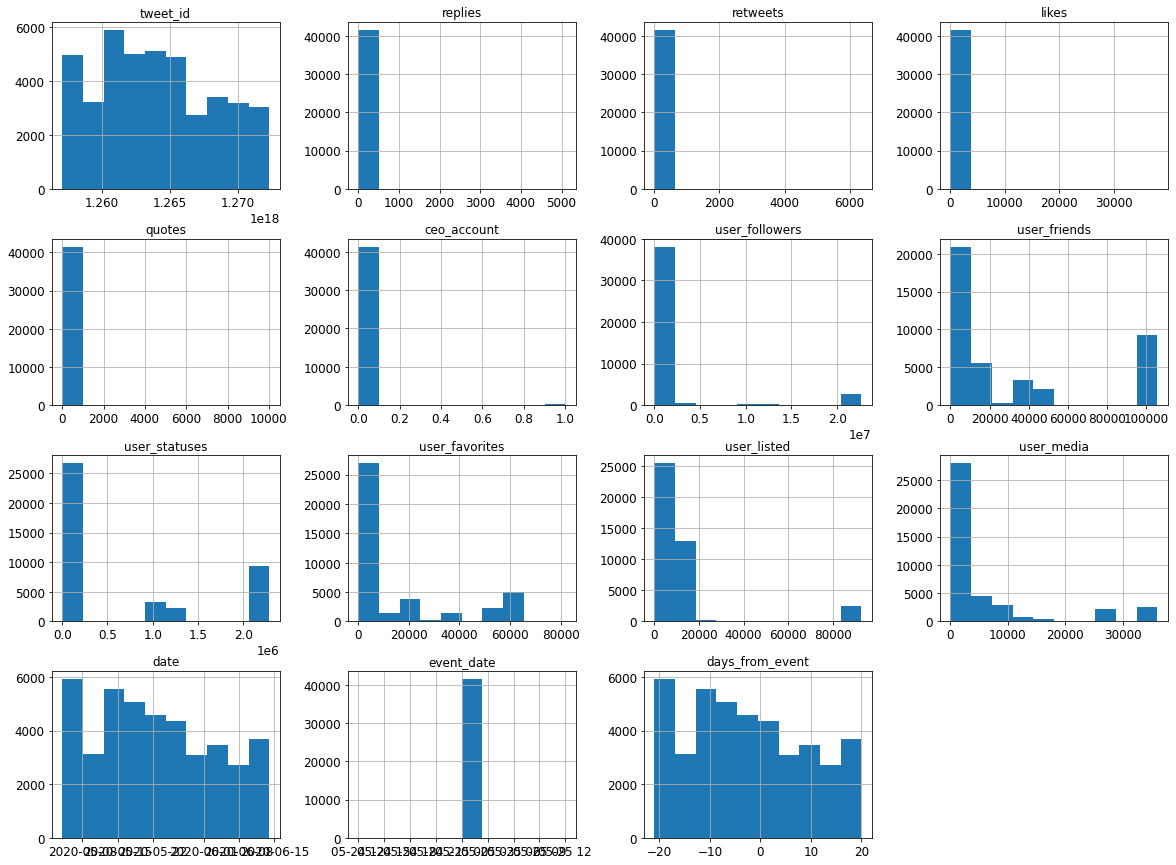

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=10, figsize=(20,15))
plt.show()

<br>
<br>
It's tough to visualize a few of these histograms (likes, quotes, replies, retweets) due to outliers at the right end of the distribution. 
<br>
<br>
As examples, looking at the value counts for the number of likes on a tweet and a histogram of tweet replies for tweets with less than 20 replies, one can see that the vast majority of tweets have zero or one likes/replies. So it appears that the data is very right skewed here. More formally, we can use scipy's skewtest, which confirms that these four  features have a larger skewness than a user's cumulative number of favorites and user's number of friends. 
<br>
<br>

In [15]:
likes_val_ct = df['likes'].value_counts()
likes_val_ct

0       28584
1        6389
2        1270
3         568
4         329
        ...  
2668        1
589         1
557         1
525         1
1439        1
Name: likes, Length: 652, dtype: int64

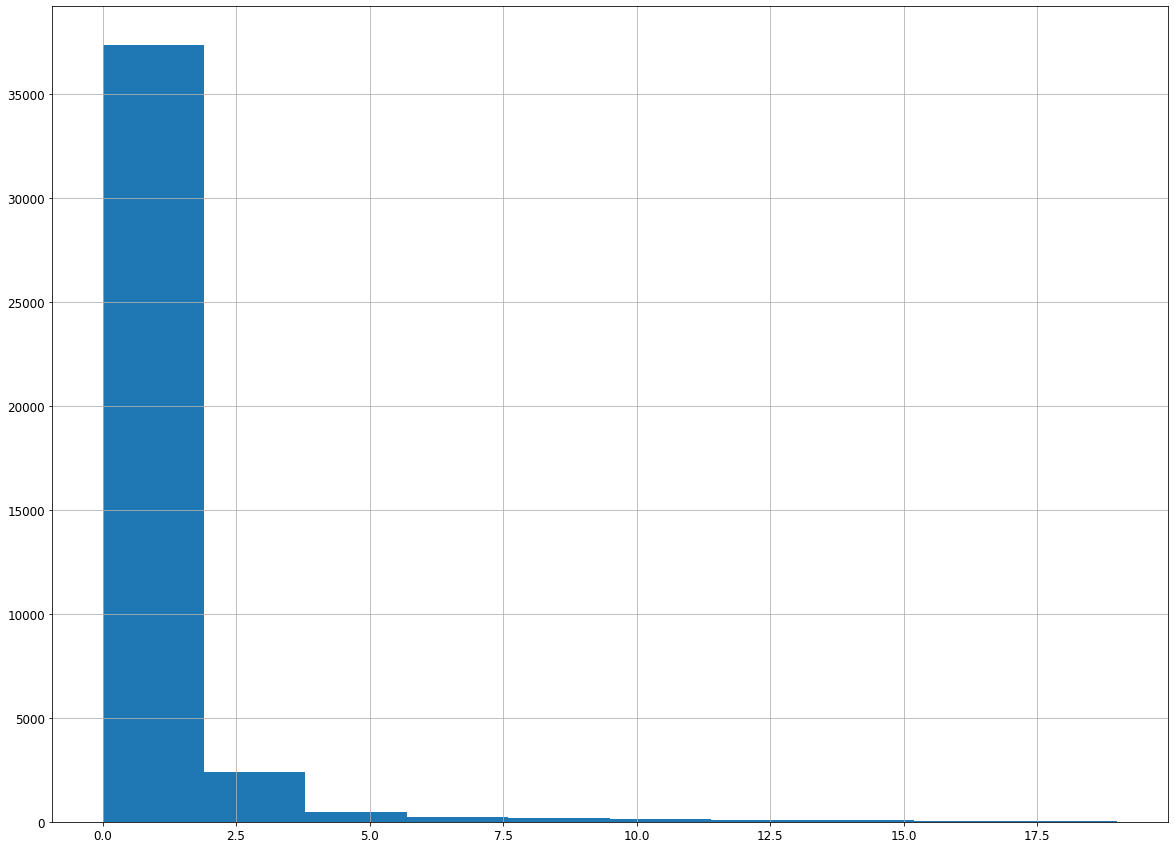

In [16]:
df_replies_cut = df[df['replies'] < 20]
df_replies_cut['replies'].hist(bins = 10, figsize=(20,15))
plt.show()

In [17]:
from scipy import stats
stats.skewtest(df[['likes', 'quotes', 'replies', 'retweets', 'user_favorites', 'user_friends']])

SkewtestResult(statistic=array([330.00300406, 415.47703778, 353.26149324, 329.52649404,
        87.70667901,  72.09676403]), pvalue=array([0., 0., 0., 0., 0., 0.]))

<br>
<br>
There are a few things worth noting from the table of summary statistics, histograms, and the data generating process. I look at each of these items in detail in the sections that follow.
<br>
<br>
1. There are notable outliers on many of the individual tweet-level features (e.g., replies, retweets), especially on the high end. These features have right-skewed distributions, with one (or more) accounts being prolific tweeters.
<br>
<br>
2. This sample has both tweets from company accounts (e.g., @Google) and associated CEO accounts (@sundarpichai). Do CEO tweets look different from company tweets? It's not hard to imagine that firms would use these two types of Twitter accounts for different purposes.
<br>
<br>
3. The large majority of tweets in the dataset are sourced through customer experience management (CXM) platforms such as Sprinklr and Conversocial (See below). Many of these tweets are one-on-one responses to customer inquiries. While the data only contains tweets in a 3 week window before and after May 25, 2020, the percentage of tweets that originate outside  strictly Twitter sources (e.g., Twitter Web App) could be seen as a rough proxy for the intensity of a company's interaction with individual consumers on Twitter. One could imagine this factor could have implications for a company's propensity to take a stance/follow-through on the stance. For example, it is reasonable to hypothesize that companies that have greater interaction with individual customers on Twitter may be more likely to find stance-taking on political issues worthwhile.
<br>
<br>

#### 1.1. What types of tweets are in the right tail of likes and retweets? 

Let's start by taking a subsample of the 20-30 tweets with the most likes and most replies. 
<br>
<br>
Below, we see that a reasonable, round-number cutoff for this cursory descriptive analysis would be <b>likes > 5000 and replies > 500 </b>
<br>
<br>

In [18]:
likes_val_ct = df['likes'].value_counts(bins=10)
likes_val_ct

(-37.998, 3799.7]     41495
(3799.7, 7599.4]         19
(7599.4, 11399.1]        11
(18998.5, 22798.2]        3
(11399.1, 15198.8]        1
(22798.2, 26597.9]        1
(26597.9, 30397.6]        1
(34197.3, 37997.0]        1
(15198.8, 18998.5]        0
(30397.6, 34197.3]        0
Name: likes, dtype: int64

In [19]:
replies_val_ct = df['replies'][df['replies'] > 10].value_counts(bins=10)
replies_val_ct

(5.917, 519.2]      813
(519.2, 1027.4]      13
(1027.4, 1535.6]      7
(1535.6, 2043.8]      1
(2043.8, 2552.0]      1
(3568.4, 4076.6]      1
(4584.8, 5093.0]      1
(2552.0, 3060.2]      0
(3060.2, 3568.4]      0
(4076.6, 4584.8]      0
Name: replies, dtype: int64

<br>
<br>
How do these small samples compare with the full sample? 
<br>
<br>
Including both the categorical and numerical data types, we can see a few interesting patterns:
<br>
<br>
(1) The most prolific Twitter user in the full sample is American Airlines, compared to Facebook in the "most replied" subsample and Apple CEO Tim Cook in the "most liked" subsample. The most common source label is a customer experience management platform (Sprinklr) in the full sample and is the Twitter Web App in the subsamples, which likely means that our subsamples filter out a good deal of the company's customer service reply tweets.
<br>
<br>
(2) The mean user attached to each tweet in the subsample has more followers, fewer friends, and fewer statuses than those in the full sample. Combined with patterns mentioned in (1), one might begin to imagine that a greater proportion of these subsample tweets are coming from publicity-friendly CEOs, who tend to engage with Twitter less often than the average company account but maintain a strong presence among their followers.
<br>
<br>

In [20]:
df.describe(include='all')

<ipython-input-20-174ba9bf1a5c>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')
<ipython-input-20-174ba9bf1a5c>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,tweet_id,text,replies,retweets,likes,quotes,media,source_label,username,ceo_account,...,user_followers,user_friends,user_statuses,user_favorites,user_listed,user_media,date,utc_time,event_date,days_from_event
count,4.153200e+04,41532,41532.000000,41532.000000,41532.000000,41532.000000,3432,41532,41532,41532.000000,...,4.153200e+04,41532.000000,4.153200e+04,41532.000000,41532.000000,41532.000000,41532,41532,41532,41532.000000
unique,NaN,41442,NaN,NaN,NaN,NaN,3,26,92,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,42,30589,1,NaN
top,NaN,@VioletReads Thank you for reaching out. Capit...,NaN,NaN,NaN,NaN,gif,Sprinklr,AmericanAir,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-20 00:00:00,130001,2020-05-25 00:00:00,NaN
freq,NaN,8,NaN,NaN,NaN,NaN,1343,15174,9319,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2147,21,41532,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-04 00:00:00,NaN,2020-05-25 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-06-14 00:00:00,NaN,2020-05-25 00:00:00,NaN
mean,1.264048e+18,NaN,2.334513,4.209935,22.442936,0.994221,NaN,NaN,NaN,0.005056,...,2.397518e+06,31872.223827,7.273061e+05,17294.113768,11626.101560,7087.116175,NaN,NaN,NaN,-2.411875
std,4.159769e+15,NaN,42.106444,66.059811,390.104113,50.880168,NaN,NaN,NaN,0.070929,...,5.336184e+06,41697.918225,9.119964e+05,21338.114912,21374.870169,9503.473712,NaN,NaN,NaN,11.481994
min,1.257098e+18,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,...,5.470000e+02,0.000000,1.440000e+02,3.000000,1.000000,27.000000,NaN,NaN,NaN,-21.000000
25%,1.260750e+18,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,...,2.488710e+05,292.000000,7.284700e+04,4986.000000,1689.000000,2237.000000,NaN,NaN,NaN,-11.000000


In [21]:
df[df['replies'] > 500].describe(include='all', datetime_is_numeric=True)

<ipython-input-21-a3479724c5ea>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df[df['replies'] > 500].describe(include='all')
<ipython-input-21-a3479724c5ea>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df[df['replies'] > 500].describe(include='all')


,tweet_id,text,replies,retweets,likes,quotes,media,source_label,username,ceo_account,...,user_followers,user_friends,user_statuses,user_favorites,user_listed,user_media,date,utc_time,event_date,days_from_event
count,2.400000e+01,24,24.000000,24.000000,24.000000,24.000000,13,24,24,24.000000,...,2.400000e+01,24.000000,2.400000e+01,24.000000,24.000000,24.000000,24,24,24,24.000000
unique,NaN,24,NaN,NaN,NaN,NaN,2,7,17,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,16,23,1,NaN
top,NaN,Amazon stands in solidarity with the Black com...,NaN,NaN,NaN,NaN,photo,Twitter Web App,Target,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-06-03 00:00:00,160001,2020-05-25 00:00:00,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,9,6,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,2,24,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-06 00:00:00,NaN,2020-05-25 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-06-12 00:00:00,NaN,2020-05-25 00:00:00,NaN
mean,1.266071e+18,NaN,1272.791667,1086.208333,5637.875000,713.250000,NaN,NaN,NaN,0.083333,...,4.121204e+06,7303.708333,1.359559e+05,11709.541667,13750.458333,6718.875000,NaN,NaN,NaN,3.041667
std,3.952215e+15,NaN,1099.133373,1771.163901,9216.384934,2007.950529,NaN,NaN,NaN,0.282330,...,6.075705e+06,13019.952569,3.084115e+05,16673.253726,21408.138454,8745.622126,NaN,NaN,NaN,10.880694
min,1.258049e+18,NaN,521.000000,43.000000,270.000000,32.000000,NaN,NaN,NaN,0.000000,...,1.605930e+05,0.000000,1.132000e+03,3.000000,1.000000,111.000000,NaN,NaN,NaN,-19.000000
25%,1.263540e+18,NaN,643.750000,136.500000,612.500000,79.500000,NaN,NaN,NaN,0.000000,...,3.429548e+05,252.750000,1.457300e+04,1822.000000,2003.250000,1811.750000,NaN,NaN,NaN,-4.000000


In [22]:
df[df['likes'] > 5000].describe(include='all', datetime_is_numeric=True)

<ipython-input-22-35c7d92bbd47>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df[df['likes'] > 5000].describe(include='all')
<ipython-input-22-35c7d92bbd47>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df[df['likes'] > 5000].describe(include='all')


,tweet_id,text,replies,retweets,likes,quotes,media,source_label,username,ceo_account,...,user_followers,user_friends,user_statuses,user_favorites,user_listed,user_media,date,utc_time,event_date,days_from_event
count,3.100000e+01,31,31.000000,31.000000,31.000000,31.000000,13,31,31,31.000000,...,3.100000e+01,31.000000,31.000000,31.000000,31.000000,31.000000,31,31,31,31.000000
unique,NaN,31,NaN,NaN,NaN,NaN,3,8,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,20,31,1,NaN
top,NaN,Who would you rather caddie for? #CapitalOnesT...,NaN,NaN,NaN,NaN,photo,Twitter Web App,tim_cook,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-20 00:00:00,025448,2020-05-25 00:00:00,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,11,10,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,31,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-04 00:00:00,NaN,2020-05-25 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-06-11 00:00:00,NaN,2020-05-25 00:00:00,NaN
mean,1.264630e+18,NaN,540.483871,1716.419355,11235.903226,541.193548,NaN,NaN,NaN,0.580645,...,5.333664e+06,778.935484,15575.516129,6122.838710,4957.451613,2720.677419,NaN,NaN,NaN,-0.838710
std,3.847160e+15,NaN,939.263785,1388.359170,7595.234494,1783.320058,NaN,NaN,NaN,0.501610,...,5.285983e+06,1738.958020,32660.407577,10439.227226,7413.133700,5384.961946,NaN,NaN,NaN,10.646116
min,1.257295e+18,NaN,36.000000,369.000000,5125.000000,7.000000,NaN,NaN,NaN,0.000000,...,4.237400e+04,51.000000,508.000000,3.000000,1.000000,85.000000,NaN,NaN,NaN,-21.000000
25%,1.262605e+18,NaN,137.000000,896.000000,6860.000000,45.000000,NaN,NaN,NaN,0.000000,...,2.185630e+05,70.000000,1132.000000,1431.500000,1.000000,111.000000,NaN,NaN,NaN,-6.500000


<br>
<br>
Now let's look at the days from the incident (where negative days indicate days prior to May 25) and the associated text of these tweets.

Although the output only contains surface level evidence, one can see strong representation of words that are associated with taking a stance on the event (e.g., "Minneapolis", "race", "using our platform"). This warrants a more rigorous text analysis with the data.
<br>
<br>

In [23]:
# Likes > 5000

df_indiv_tweets = df[['date','days_from_event', 'text', 'replies', 'retweets', 'likes', 'quotes', 'source_label', 'compustat_company']]
df_indiv_tweets[['days_from_event','text']][df_indiv_tweets['likes']>5000]

,days_from_event,text
3,17,"Android 11 is now available in beta, with a fo..."
4,6,Today on US Google &amp; YouTube homepages we ...
9,-5,The #COVID19 Exposure Notification technology ...
11,-13,We've re-engineered Google Meet to make secure...
18,17,The unfinished work of racial justice and equa...
19,10,"Today, as Minneapolis gathers and the nation m..."
20,4,Minneapolis is grieving for a reason. To parap...
22,0,We will never forget the memory and sacrifice ...
23,-2,"Wishing safety, happiness and peace to those c..."
26,-5,Technology can help health officials rapidly t...


In [24]:
# Replies > 500
df_indiv_tweets[['days_from_event','text']][df_indiv_tweets['replies']>500]

,days_from_event,text
4,6,Today on US Google &amp; YouTube homepages we ...
18,17,The unfinished work of racial justice and equa...
1339,9,"Today Googlers are holding an 8-minute, 46-sec..."
3381,9,Amazon stands in solidarity with the Black com...
3383,6,https://t.co/yI4MYEDz4C
15207,-5,We're all in for the release of the #JusticeLe...
16521,-2,Who would you rather caddie for? #CapitalOnesT...
16570,11,black lives matter. words from our leaders: ht...
17336,14,"Racism, hate and inequality have no place in o..."
18465,18,Hatred and discrimination have no place in our...


<br>
<br>
We can also take a look at kernel density distributions of these subsamples of tweets compared to the full sample. 

Compared to the full sample and a less constrained cut of the data (1000 most liked/replied tweets), the subsamples have a notable center of mass at the event date and just right of the event date. This is especially true for tweets with many replies. The tweets with the most replies peak around a week after the event.

Coupled with the cursory analysis above, it appears that political stance tweets may attract significant attention relative to the average corporate tweet.
<br>
<br>

Text(0.5, 1.0, 'Density of Tweets with Different Amounts of Likes')

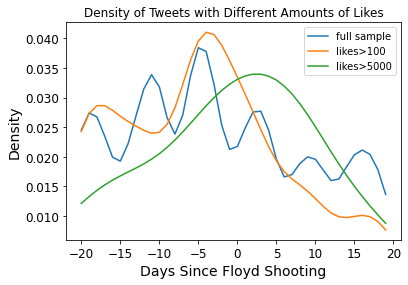

In [25]:
# Full Sample of Tweets (n~45,000), >100 Likes (n~1000), >5000 Likes (n~30)
ax = df_indiv_tweets['days_from_event'].plot.kde(ind=np.arange(-20, 20, 1).tolist(), legend=True)
l_100 = df_indiv_tweets['days_from_event'][df_indiv_tweets['likes']>100].plot.kde(ind=np.arange(-20, 20, 1).tolist(), ax=ax, legend=True)
l_5000 = df_indiv_tweets['days_from_event'][df_indiv_tweets['likes']>5000].plot.kde(ind=np.arange(-20, 20, 1).tolist(), ax=ax, legend=True)
ax.set_xlabel("Days Since Floyd Incident")
ax.legend(['full sample', 'likes>100', 'likes>5000'])
ax.set_title('Density of Tweets with Different Amounts of Likes')


Text(0.5, 1.0, 'Density of Tweets with Different Amounts of Replies')

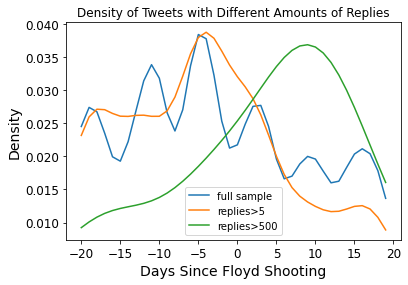

In [26]:
# Full Sample of Tweets (n~45,000), >5 Replies (n~1000), >500 Replies (n~30)

ax = df_indiv_tweets['days_from_event'].plot.kde(ind=np.arange(-20, 20, 1).tolist(), legend=True)
l_100 = df_indiv_tweets['days_from_event'][df_indiv_tweets['replies']>5].plot.kde(ind=np.arange(-20, 20, 1).tolist(), ax=ax, legend=True)
l_5000 = df_indiv_tweets['days_from_event'][df_indiv_tweets['replies']>500].plot.kde(ind=np.arange(-20, 20, 1).tolist(), ax=ax, legend=True)
ax.set_xlabel("Days Since Floyd Incident")
ax.legend(['full sample', 'replies>5', 'replies>500'])
ax.set_title('Density of Tweets with Different Amounts of Replies')

#### 1.2 How do CEO tweets differ from company tweets?

Let's start by looking at basic summary statistics broken down by account type
<br>
<br>

In [27]:
with pd.option_context('display.max_columns', 40):
    print(df[df['ceo_account']==1].describe(include='all', datetime_is_numeric=True))

            tweet_id                                               text  \
count   2.100000e+02                                                210   
unique           NaN                                                210   
top              NaN  Lately, we’ve used #DowStrong to share about @...   
freq             NaN                                                  1   
first            NaN                                                NaN   
last             NaN                                                NaN   
mean    1.262833e+18                                                NaN   
std     3.897574e+15                                                NaN   
min     1.257161e+18                                                NaN   
25%     1.259203e+18                                                NaN   
50%     1.262784e+18                                                NaN   
75%     1.265407e+18                                                NaN   
max     1.271433e+18     

<ipython-input-27-2307da4519c7>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df[df['ceo_account']==1].describe(include='all'))
<ipython-input-27-2307da4519c7>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df[df['ceo_account']==1].describe(include='all'))


In [28]:
with pd.option_context('display.max_columns', 40):
    print(df[df['ceo_account']==0].describe(include='all', datetime_is_numeric=True))

<ipython-input-28-9c47e4eacc43>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df[df['ceo_account']==0].describe(include='all'))


            tweet_id                                               text  \
count   4.132200e+04                                              41322   
unique           NaN                                              41232   
top              NaN  @VioletReads Thank you for reaching out. Capit...   
freq             NaN                                                  8   
first            NaN                                                NaN   
last             NaN                                                NaN   
mean    1.264054e+18                                                NaN   
std     4.160197e+15                                                NaN   
min     1.257098e+18                                                NaN   
25%     1.260759e+18                                                NaN   
50%     1.263552e+18                                                NaN   
75%     1.267455e+18                                                NaN   
max     1.272317e+18     

<ipython-input-28-9c47e4eacc43>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df[df['ceo_account']==0].describe(include='all'))


Each marginal tweet from a CEO account appears to be much more influential than corporate accounts if we consider mean numbers of likes, replies, retweets, and quotes. Corporate accounts, in contrast, have larger mean values for the user features (e.g., followers, friends), which is understandable since these accounts tend to be established and long-lived, as opposed to the average CEO who might use Twitter most intensely in their corporate role but lower their activity after leaving the CEO role.

CEOs tend to source their tweets through the Twitter Web App, while companies tend to source them through customer management experience (CXM) platforms, strongly suggesting that CEOs are using the platform to broadcast content to a wide audience and company accounts are mostly being used to address individual customer service inquiries.

The most prolific tweeter in our sample is Dell CEO Michael Dell, with 45 tweets over the six-week study period. Importantly, large amounts of tweets do not seem to translate into highly liked tweets, given that we found Apple CEO Tim Cook to have the most tweets with more than 5,000 likes in our sample. Twitter itself is just one outlet in the social world, so it can both influence social factors in the outside world as well as be shaped by them.  
<br>
<br>

Looking slightly more deeply at the data, we can see that the majority of the most liked tweets (>5,000 likes) come from CEO accounts with the majority coming from only three CEOs: Alphabet CEO Sundar Pichai, Apple CEO Tim Cook, and Disney CEO Bob Iger. Interestingly, Tim Cook only tweeted 15 times during this period, and the majority (9) of his tweets received over 5,000 likes.

If we turn to tweets with the most number of replies (>500), however, the pattern of relatively greater CEO influence is less clear. The large majority of the tweets that generate the largest number of replies come from corporate accounts. It's worth noting that corporate accounts tend to have larger follower and friend bases than CEOs, which may account for the greater number of replies. Public twitter account users are also able to limit who can reply to tweets (everyone, friends, no replies), which may also inflate corporate reply numbers given the larger relative friend base. Finally, it's worth noting that the two CEO tweets that have more than 500 replies is proportionally greater than their relative presence in the total sample, in which CEOs are responsible for only 0.5% of all tweets. Being less restrictive in defining "highly replied" tweets (<400) maintains this relatively high CEO presence compared to the full sample. 

In sum, looking at either the most liked or most replied tweets suggests an outsized, influential role for CEO tweets in this sample.
<br>
<br>

In [29]:
df[['text', 'username', 'likes', 'date']][df['likes']>5000]

,text,username,likes,date
3,"Android 11 is now available in beta, with a fo...",sundarpichai,5377,2020-06-11
4,Today on US Google &amp; YouTube homepages we ...,sundarpichai,37997,2020-05-31
9,The #COVID19 Exposure Notification technology ...,sundarpichai,5643,2020-05-20
11,We've re-engineered Google Meet to make secure...,sundarpichai,6081,2020-05-12
18,The unfinished work of racial justice and equa...,tim_cook,19542,2020-06-11
19,"Today, as Minneapolis gathers and the nation m...",tim_cook,10957,2020-06-04
20,Minneapolis is grieving for a reason. To parap...,tim_cook,20071,2020-05-29
22,We will never forget the memory and sacrifice ...,tim_cook,6921,2020-05-25
23,"Wishing safety, happiness and peace to those c...",tim_cook,11642,2020-05-23
26,Technology can help health officials rapidly t...,tim_cook,9343,2020-05-20


In [30]:
df[['text', 'username', 'likes', 'date']][df['replies']>500]

,text,username,likes,date
4,Today on US Google &amp; YouTube homepages we ...,sundarpichai,37997,2020-05-31
18,The unfinished work of racial justice and equa...,tim_cook,19542,2020-06-11
1339,"Today Googlers are holding an 8-minute, 46-sec...",Google,1490,2020-06-03
3381,Amazon stands in solidarity with the Black com...,amazon,1379,2020-06-03
3383,https://t.co/yI4MYEDz4C,amazon,10040,2020-05-31
15207,We're all in for the release of the #JusticeLe...,ATT,8762,2020-05-20
16521,Who would you rather caddie for? #CapitalOnesT...,CapitalOne,5166,2020-05-23
16570,black lives matter. words from our leaders: ht...,Chevron,455,2020-06-05
17336,"Racism, hate and inequality have no place in o...",comcast,1295,2020-06-08
18465,Hatred and discrimination have no place in our...,JohnDeere,1172,2020-06-12


#### 1.3. How do tweets from non-Twitter sources compare to those from Twitter sources?

As previously noted, most of the tweets in this sample are sourced through outside customer experience management (CXM) platforms. Many of these CXM tweets are one-on-one discussions with individual customers, usually about some sort of customer service issue. Let's examine whether there are differences in the tweets sourced through these outlets versus those sourced directly through Twitter. 
<br>
<br>
Before going any further, it's worth noting that not <b>all</b> of these CXM tweets are simply customer service issues. As an example related to the previous section, many of the most liked tweets in this time period were sourced through CXM platforms. A few of these, like Amazon's tweet with a URL in the text field, are clear public political stances.
<br>
<br>

In [31]:
df_indiv_tweets[['days_from_event','text','source_label', 'compustat_company']][df_indiv_tweets['likes']>5000]

,days_from_event,text,source_label,compustat_company
3,17,"Android 11 is now available in beta, with a fo...",Twitter Web App,ALPHABET INC
4,6,Today on US Google &amp; YouTube homepages we ...,Twitter Web App,ALPHABET INC
9,-5,The #COVID19 Exposure Notification technology ...,Twitter Web App,ALPHABET INC
11,-13,We've re-engineered Google Meet to make secure...,Twitter Web App,ALPHABET INC
18,17,The unfinished work of racial justice and equa...,Twitter Media Studio,APPLE INC
19,10,"Today, as Minneapolis gathers and the nation m...",Twitter Web App,APPLE INC
20,4,Minneapolis is grieving for a reason. To parap...,Twitter for iPhone,APPLE INC
22,0,We will never forget the memory and sacrifice ...,Twitter for iPad,APPLE INC
23,-2,"Wishing safety, happiness and peace to those c...",Twitter for iPhone,APPLE INC
26,-5,Technology can help health officials rapidly t...,Twitter for iPad,APPLE INC


In [32]:
df['twitter_source'] = (df.source_label.str[:7] == "Twitter")

In [33]:
df[['source_label', 'twitter_source']]

,source_label,twitter_source
0,Twitter Web App,True
1,Twitter Web App,True
2,Twitter Web App,True
3,Twitter Web App,True
4,Twitter Web App,True
...,...,...
41527,Sprinklr,False
41528,Sprinklr,False
41529,Sprinklr,False
41530,Sprinklr,False


<br>
<br>
Looking at summary statistics of the features with numerical data types, we can see that the average Twitter-sourced tweet has, on average, more replies, retweets, likes, and quotes than the average tweet from non-Twitter sources. This provides supporting evidence behind the idea that companies may tend to outsource Twitter engagement that might not be of interest to the general public.
<br>
<br>

In [34]:
df[df['twitter_source']==True].describe()

,tweet_id,replies,retweets,likes,quotes,ceo_account,user_followers,user_friends,user_statuses,user_favorites,user_listed,user_media,days_from_event
count,2.108000e+03,2108.000000,2108.000000,2108.000000,2108.000000,2108.000000,2.108000e+03,2108.000000,2.108000e+03,2108.000000,2108.000000,2108.000000,2108.000000
mean,1.263099e+18,19.545066,48.064991,266.647059,7.676471,0.097723,1.786739e+06,7134.664137,9.329830e+04,13012.962524,7383.585389,7805.670304,-5.100095
std,4.135872e+15,88.496283,266.196802,1579.629106,47.564247,0.297010,4.600971e+06,11796.927884,2.530311e+05,17813.310429,17484.791406,10366.363239,11.406621
min,1.257132e+18,0.000000,0.000000,0.000000,0.000000,0.000000,7.310000e+02,6.000000,1.440000e+02,3.000000,1.000000,27.000000,-21.000000
25%,1.259537e+18,0.000000,0.000000,3.000000,0.000000,0.000000,5.819700e+04,532.000000,5.077000e+03,1913.000000,807.000000,1267.000000,-15.000000
50%,1.262771e+18,1.000000,4.000000,19.000000,0.000000,0.000000,3.743160e+05,2061.000000,1.840500e+04,4656.000000,2622.000000,3015.000000,-6.000000
75%,1.266061e+18,8.000000,16.000000,73.250000,2.000000,0.000000,9.054380e+05,9050.000000,1.265700e+05,12952.000000,5503.000000,6857.000000,3.000000
max,1.272269e+18,1737.000000,6360.000000,37997.000000,1278.000000,1.000000,2.265206e+07,105648.000000,2.285343e+06,81858.000000,92884.000000,35995.000000,20.000000


In [35]:
df[df['twitter_source']==False].describe()

,tweet_id,replies,retweets,likes,quotes,ceo_account,user_followers,user_friends,user_statuses,user_favorites,user_listed,user_media,days_from_event
count,3.942400e+04,39424.000000,39424.000000,39424.000000,39424.000000,39424.000000,3.942400e+04,39424.000000,3.942400e+04,39424.000000,39424.000000,39424.000000,39424.000000
mean,1.264099e+18,1.414265,1.865006,9.385349,0.636922,0.000101,2.430176e+06,33194.940341,7.612065e+05,17523.026786,11852.948762,7048.695110,-2.268136
std,4.154999e+15,37.848415,26.489312,153.620932,51.027331,0.010072,5.370758e+06,42305.775945,9.220341e+05,21486.504157,21539.778286,9453.722162,11.468420
min,1.257098e+18,0.000000,0.000000,0.000000,0.000000,0.000000,5.470000e+02,0.000000,1.550000e+02,5.000000,9.000000,48.000000,-21.000000
25%,1.260910e+18,0.000000,0.000000,0.000000,0.000000,0.000000,2.488710e+05,292.000000,1.026260e+05,4986.000000,2196.000000,2237.000000,-11.000000
50%,1.263591e+18,0.000000,0.000000,0.000000,0.000000,0.000000,1.082204e+06,12133.000000,1.630220e+05,5282.000000,6251.000000,2947.000000,-4.000000
75%,1.267484e+18,1.000000,0.000000,1.000000,0.000000,0.000000,1.603666e+06,42896.000000,1.237612e+06,19922.000000,11311.000000,6857.000000,7.000000
max,1.272317e+18,5093.000000,1952.000000,10862.000000,10016.000000,1.000000,2.265206e+07,105648.000000,2.285343e+06,81858.000000,92884.000000,35995.000000,20.000000


### 2. Merging Data from Compustat

The tweet data can only tell us so much about the landscape of companies and CEOs tweeting public political stances. To provide further individual, organizational, and industry details on the account users and tweeting trends, I merge data from Compustat's Execucomp database, which contains data on individual CEOs (e.g., tenure at company), companies, and industries.

To simplify this analysis, I will match each tweet with the company's data from the year 2020. It's worth noting that some Fortune 100 companies do not appear in the dataset. Execucomp matches publicly traded companies by their stock ticker, so companies can fall out fo the dataset for reasons as diverse as not having a single primary stock ticker (e.g., Berkshire Hathaway) or not being publicly traded during the entire year (e.g., Albertsons). There are 80 Twitter-active company accounts and 12 Twitter-active CEOs in this dataset. 

Merging will be done on the "compustat_company" feature in order to retain the baseline dataset of tweets. This is a one-to-many join, where we are matching one instance of Compustat data per company to many tweet instances from the same company (or the associated company's CEO).
<br>
<br>

In [36]:
# Join the Compustat dataset based on the "compustat_company" key

compustat_df = pd.read_csv('compustat_data.csv')

In [37]:
compustat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4744 entries, 0 to 4743
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EXEC_FULLNAME      4744 non-null   object 
 1   EXECRANK           389 non-null    float64
 2   CO_PER_ROL         4744 non-null   int64  
 3   compustat_company  4744 non-null   object 
 4   CEOANN             848 non-null    object 
 5   AGE                4740 non-null   float64
 6   GVKEY              4744 non-null   int64  
 7   YEAR               4744 non-null   int64  
 8   BECAMECEO          1237 non-null   float64
 9   JOINED_CO          441 non-null    float64
 10  LEFTOFC            647 non-null    float64
 11  PCEO               655 non-null    object 
 12  TITLE              4178 non-null   object 
 13  GENDER             4744 non-null   object 
 14  CITY               4744 non-null   object 
 15  STATE              4744 non-null   object 
 16  NAICSDESC          4744 

In [38]:
# Delete rows from compustat_df that aren't year == 2019, merge into tweets df.

compustat_df = compustat_df[compustat_df['YEAR']==2019]  
compustat_df = compustat_df[compustat_df['CEOANN']=='CEO']
compustat_df.head()

,EXEC_FULLNAME,EXECRANK,CO_PER_ROL,compustat_company,CEOANN,AGE,GVKEY,YEAR,BECAMECEO,JOINED_CO,LEFTOFC,PCEO,TITLE,GENDER,CITY,STATE,NAICSDESC,TICKER,NAICS
54,William Douglas Parker,NaN,49256,AMERICAN AIRLINES GROUP INC,CEO,57.0,1045,2019,20131209.0,NaN,NaN,CEO,Chairman & CEO,MALE,Fort Worth,TX,Scheduled Passenger Air Transportation,AAL,481111
107,Darius E. Adamczyk,NaN,54028,HONEYWELL INTERNATIONAL INC,CEO,53.0,1300,2019,20170331.0,NaN,NaN,CEO,"Chairman of the Board, CEO & President",MALE,Charlotte,NC,Other Aircraft Parts and Auxiliary Equipment M...,HON,336413
161,Stephen Joseph Squeri,NaN,37051,AMERICAN EXPRESS CO,CEO,59.0,1447,2019,20180201.0,NaN,NaN,CEO,Chairman & CEO,MALE,New York,NY,Credit Card Issuing,AXP,522210
225,Brian Charles Duperreault,NaN,59845,AMERICAN INTERNATIONAL GROUP,CEO,72.0,1487,2019,20170514.0,NaN,NaN,CEO,CEO & Director,MALE,New York,NY,Direct Property and Casualty Insurance Carriers,AIG,524126
281,Timothy D. Cook,NaN,15741,APPLE INC,CEO,58.0,1690,2019,20110824.0,19980201.0,NaN,CEO,CEO & Director,MALE,Cupertino,CA,Radio and Television Broadcasting and Wireless...,AAPL,334220


In [39]:
compustat_df['YEAR'].value_counts()

2019    84
Name: YEAR, dtype: int64

In [40]:
df_merged = pd.merge(df, compustat_df, how='inner', on=['compustat_company'])
df_merged.head()

,tweet_id,text,replies,retweets,likes,quotes,media,source_label,username,ceo_account,...,JOINED_CO,LEFTOFC,PCEO,TITLE,GENDER,CITY,STATE,NAICSDESC,TICKER,NAICS
0,1271235256918487040,An important update from @SusanWojcicki on how...,85,187,1689,14,NaN,Twitter Web App,sundarpichai,1,...,NaN,NaN,CEO,CEO & Director,MALE,Mountain View,CA,"Data Processing, Hosting, and Related Services...",GOOGL,518210
1,1270968380304941058,Proud that @GoogleCloud is partnering with @Te...,71,416,1937,47,NaN,Twitter Web App,sundarpichai,1,...,NaN,NaN,CEO,CEO & Director,MALE,Mountain View,CA,"Data Processing, Hosting, and Related Services...",GOOGL,518210
2,1270957112097570816,Also excited that in #Android11 we're making i...,89,406,3020,48,NaN,Twitter Web App,sundarpichai,1,...,NaN,NaN,CEO,CEO & Director,MALE,Mountain View,CA,"Data Processing, Hosting, and Related Services...",GOOGL,518210
3,1270954939309645824,"Android 11 is now available in beta, with a fo...",152,707,5377,45,NaN,Twitter Web App,sundarpichai,1,...,NaN,NaN,CEO,CEO & Director,MALE,Mountain View,CA,"Data Processing, Hosting, and Related Services...",GOOGL,518210
4,1267094364976672768,Today on US Google &amp; YouTube homepages we ...,1737,6360,37997,700,photo,Twitter Web App,sundarpichai,1,...,NaN,NaN,CEO,CEO & Director,MALE,Mountain View,CA,"Data Processing, Hosting, and Related Services...",GOOGL,518210


In [41]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41532 entries, 0 to 41531
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   tweet_id           41532 non-null  int64         
 1   text               41532 non-null  object        
 2   replies            41532 non-null  int64         
 3   retweets           41532 non-null  int64         
 4   likes              41532 non-null  int64         
 5   quotes             41532 non-null  int64         
 6   media              3432 non-null   object        
 7   source_label       41532 non-null  object        
 8   username           41532 non-null  object        
 9   ceo_account        41532 non-null  int64         
 10  compustat_company  41532 non-null  object        
 11  user_join_date     41532 non-null  object        
 12  user_followers     41532 non-null  int64         
 13  user_friends       41532 non-null  int64         
 14  user_s

<br><br>
Out of the 84 companies in our sample, we see that the mean CEO age is 57 years old, roughly 90% are male, and have served as CEO on average for 5 years. While only about 15% of CEOs have data on the year they joined their company, it appears that many CEOs are long-lived employees at their firms, with this subsample having originally joined their firm in 1988 on average.

A wide variety of industries are represented in this data. From looking at value counts of tweets per industry, there appears to be a rough trend that many of the most prolific tweeters are B2C companies (e.g., airlines, wireless providers, grocery stores) and some of the least prolific tweeters are B2B companies (e.g., oil and gas drilling, manufacturing for intermediate products). Paired with the descriptive analysis of the CXM sources, it appears that customer-facing companies (especially airlines) use Twitter as a way to interact with individual customers, who may be more likely to post customer service inquiries on Twitter than customers of B2B companies. 

It's also worth noting that corporate actions with respect to the COVID-19 pandemic may be leading to especially high numbers of tweets among some accounts. For example, Kroger drew criticism during this time period for their [HR decisions](https://www.cbsnews.com/news/kroger-workers-extra-coronavirus-pay-return/) regarding employee pay and hours during the the pandemic. I have designed the main analysis to deal with these outliers and understand how they may impact results.
<br><br>

In [42]:
with pd.option_context('display.max_columns', 40):
    print(df_merged.describe(include='all', datetime_is_numeric=True))

            tweet_id                                               text  \
count   4.153200e+04                                              41532   
unique           NaN                                              41442   
top              NaN  @VioletReads Thank you for reaching out. Capit...   
freq             NaN                                                  8   
first            NaN                                                NaN   
last             NaN                                                NaN   
mean    1.264048e+18                                                NaN   
std     4.159769e+15                                                NaN   
min     1.257098e+18                                                NaN   
25%     1.260750e+18                                                NaN   
50%     1.263550e+18                                                NaN   
75%     1.267451e+18                                                NaN   
max     1.272317e+18     

<ipython-input-42-33c7a49be83c>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df_merged.describe(include='all'))
<ipython-input-42-33c7a49be83c>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df_merged.describe(include='all'))


In [43]:
df_merged['NAICSDESC'].value_counts()

Scheduled Passenger Air Transportation                14791
Supermarkets and Other Grocery (except Convenience     5062
Wireless Telecommunications Carriers (except Satel     4374
Home Centers                                           3657
Data Processing, Hosting, and Related Services (ef     2582
Couriers and Express Delivery Services                 1437
Cable and Other Subscription Programming               1230
Internet Publishing and Broadcasting and Web Searc      972
Direct Property and Casualty Insurance Carriers         871
All Other General Merchandise Stores (eff from 6/3      786
Automobile and Light Duty Motor Vehicle Manufactur      635
Credit Card Issuing                                     488
Investment Banking and Securities Dealing               397
Electronic Shopping and Mail-Order Houses               367
Soap and Other Detergent Manufacturing                  349
Electronics Stores                                      318
Direct Health and Medical Insurance Carr

In [44]:
df['username'][df['twitter_source']!=1].value_counts()

AmericanAir      9310
kroger           5058
Lowes            3484
Delta            3264
Google           2488
                 ... 
Prudential          3
JimFitterling       3
Sysco               2
HCAhealthcare       1
MichaelDell         1
Name: username, Length: 72, dtype: int64

<br><br>
#### Create datasets for Upwork

Below, I create two binary features (<i>floyd_stance</i>, which is 1 for the account's initial tweet stance and <i>floyd_followup</i>, which is 1 for any stance related to racial justice, policing reform, etc.). These columns are all set to 0, and Upworkers will change them to 1 per the feature definitions. I create a hash column in both the merged dataset and upwork dataset to allow for unique one-to-one matches upon merging in completed data from upwork.

I divide the dataset into 6 sub-datasets for Upworkers. I manually manipulate data in Excel to ensure that each account is fully contained within one sub-dataset. Each Upworker will append their finished dataset with either "\_a" or "\_b", and no Upworker can provide two completed versions of a subdataset (i.e., each dataset's two raters will be unique).
<br><br>

In [45]:
df_merged['floyd_stance'] = 0
df_merged['floyd_followup'] = 0
df_merged['hash'] = pd.util.hash_pandas_object(df_merged) # To avoid re-setting hash values, uncomment to reset
df_merged['hash'] = 'h' + df_merged['hash'].astype(str)
df_merged['hash'].head()


0     h8605051277002103613
1    h15717766445324181553
2    h14387640981333171160
3    h12056933943932526041
4     h4607050225701582760
Name: hash, dtype: object

In [47]:
df_merged.to_csv('data_merged.csv', index=False)
df_merged.to_pickle('data_merged.pkl', protocol=4)

In [ ]:
df_upwork = df_merged[['floyd_stance', 'floyd_followup', 'username', 'date', 'text', 'hash']]
df_upwork = df_upwork.sort_values(['username', 'date'], ascending=[True, True])
df_upwork.reset_index(drop=True, inplace=True)  # We'll match on the hash value for the future merge

In [ ]:
df_len = len(df_upwork)
df_len

In [49]:
# Divide up dataset for Upwork. Note that 41,532 is divisible by 6 (digits sum to 15, which is divisible by 3). 
# This leaves roughly 7,000 instances per dataset for Upworkers.

# Create 6 df slices, divide up work into 6 dfs.
dfnames = ['df_u_1', 'df_u_2', 'df_u_3', 'df_u_4', 'df_u_5', 'df_u_6']
df_u_list = [pd.DataFrame for x in dfnames]

size = int(df_len/6)
list_of_dfs = [df_upwork.loc[i:i+size-1,:] for i in range(0, len(df),size)]

df_dict = {dfnames[i]: list_of_dfs[i] for i in range(len(dfnames))} 

#Create and change directory
change_dir(PROJECT_ROOT, "/data/upwork_rater_data")

for name, frame in df_dict.items():
    frame.to_csv(name+'.csv', index=False)
    
df_upwork.to_csv('df_u_full.csv', index=False)

In [50]:
df_merged.head()

,tweet_id,text,replies,retweets,likes,quotes,media,source_label,username,ceo_account,...,TITLE,GENDER,CITY,STATE,NAICSDESC,TICKER,NAICS,floyd_stance,floyd_followup,hash
0,1271235256918487040,An important update from @SusanWojcicki on how...,85,187,1689,14,NaN,Twitter Web App,sundarpichai,1,...,CEO & Director,MALE,Mountain View,CA,"Data Processing, Hosting, and Related Services...",GOOGL,518210,0,0,h8605051277002103613
1,1270968380304941058,Proud that @GoogleCloud is partnering with @Te...,71,416,1937,47,NaN,Twitter Web App,sundarpichai,1,...,CEO & Director,MALE,Mountain View,CA,"Data Processing, Hosting, and Related Services...",GOOGL,518210,0,0,h15717766445324181553
2,1270957112097570816,Also excited that in #Android11 we're making i...,89,406,3020,48,NaN,Twitter Web App,sundarpichai,1,...,CEO & Director,MALE,Mountain View,CA,"Data Processing, Hosting, and Related Services...",GOOGL,518210,0,0,h14387640981333171160
3,1270954939309645824,"Android 11 is now available in beta, with a fo...",152,707,5377,45,NaN,Twitter Web App,sundarpichai,1,...,CEO & Director,MALE,Mountain View,CA,"Data Processing, Hosting, and Related Services...",GOOGL,518210,0,0,h12056933943932526041
4,1267094364976672768,Today on US Google &amp; YouTube homepages we ...,1737,6360,37997,700,photo,Twitter Web App,sundarpichai,1,...,CEO & Director,MALE,Mountain View,CA,"Data Processing, Hosting, and Related Services...",GOOGL,518210,0,0,h4607050225701582760
